In [2]:
import pandas as pd
import numpy as np
import os
import cv2

from metods import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
from matplotlib import image

from skimage.io import imread

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
PADDING = 40

models_folder = "models\\"

modelName = models_folder + "LungIdentifierModel.h5"

TRAINING_MODE = True
KAGGLE_MODE = False

healty_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty\\"
healty_mask_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty Mask\\"
healty_segmented_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty Segmented\\"

pneu_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax\\"
pneu_mask_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax Mask\\"
pneu_segmented_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax Segmented\\"

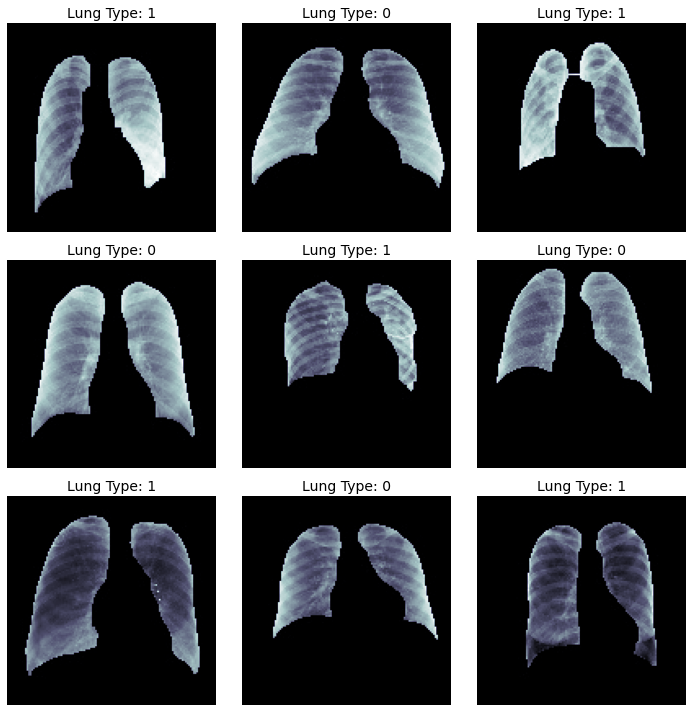

In [4]:
test_id_list = [
'NIH Data\\Healty Segmented\\segment_00000037_000.png',
'NIH Data\\Pneumothorax Segmented\\segment_00000832_004.png',
'NIH Data\\Healty Segmented\\segment_00000070_000.png',
'NIH Data\\Pneumothorax Segmented\\segment_00001376_008.png',
'NIH Data\\Healty Segmented\\segment_00000190_000.png',
'NIH Data\\Pneumothorax Segmented\\segment_00001951_013.png',
'NIH Data\\Healty Segmented\\segment_00000242_001.png',
'NIH Data\\Pneumothorax Segmented\\segment_00002316_006.png',
'NIH Data\\Healty Segmented\\segment_00000272_002.png',
'NIH Data\\Pneumothorax Segmented\\segment_00002492_002.png']

types = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

X_test = np.zeros((len(test_id_list), IMG_HEIGHT, IMG_WIDTH))

for i, img_id in enumerate(test_id_list):
    img = readImages(img_id)
    X_test[i] = img

plt.figure(figsize=(10,10))
plt.axis('Off')

for i in range(1, 10):
    plt.subplot(3,3,i)
    test_image = X_test[i, :, :]
    plt.imshow(test_image, cmap=plt.cm.bone)
    plt.title(f'Lung Type: {types[i]}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
healty_segmented_images = os.listdir(healty_segmented_path)
pneu_segmented_images = os.listdir(pneu_segmented_path)

X_train = np.zeros((len(healty_segmented_images) + len(pneu_segmented_images), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_train = np.zeros((len(healty_segmented_images) + len(pneu_segmented_images)), dtype=np.bool)

for i, img_id in enumerate(healty_segmented_images):
    file_name = healty_segmented_path + img_id

    img = readImages(file_name, is_gray=0)
    
    X_train[i] = img
    Y_train[i] = 0

for i, img_id in enumerate(pneu_segmented_images):
    file_name = pneu_segmented_path + img_id
    
    img = readImages(file_name, is_gray=0)
    
    X_train[len(healty_segmented_images) + i] = img
    Y_train[len(healty_segmented_images) + i] = 1

X_train = X_train.reshape(-1, 128, 128, 1)

print(X_train.shape)
print(Y_train.shape)

(3630, 128, 128, 1)
(3630,)


In [6]:
#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [7]:
kernel_size = (5,5) #5,5
pool_size= (2, 2) #2,2
first_filters = 32 #32
second_filters = 64 #64
third_filters = 128 #128

dropout_conv = 0.3 #3
dropout_dense = 0.3 #3

model = Sequential()

model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (128,128,1)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())

model.add(Dense(1024))
model.add(LeakyReLU())
model.add(BatchNormalization())

model.add(Dense(512))
model.add(LeakyReLU())
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 204, 204, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 64)        5

Epoch 1/200
182/182 [==============================] - 80s 202ms/step - loss: 1.1287 - accuracy: 0.5185 - val_loss: 0.7433 - val_accuracy: 0.5496

Epoch 00001: val_accuracy improved from -inf to 0.54959, saving model to models\LungIdentifierModel.h5
Epoch 2/200
182/182 [==============================] - 11s 61ms/step - loss: 0.7276 - accuracy: 0.5620 - val_loss: 0.7337 - val_accuracy: 0.4105

Epoch 00002: val_accuracy did not improve from 0.54959
Epoch 3/200
182/182 [==============================] - 11s 62ms/step - loss: 0.6926 - accuracy: 0.5903 - val_loss: 0.7085 - val_accuracy: 0.4105

Epoch 00003: val_accuracy did not improve from 0.54959
Epoch 4/200
182/182 [==============================] - 11s 61ms/step - loss: 0.6895 - accuracy: 0.5670 - val_loss: 0.6987 - val_accuracy: 0.4848

Epoch 00004: val_accuracy did not improve from 0.54959
Epoch 5/200
182/182 [==============================] - 11s 61ms/step - loss: 0.6960 - accuracy: 0.5583 - val_loss: 0.8435 - val_accuracy: 0.5909

E

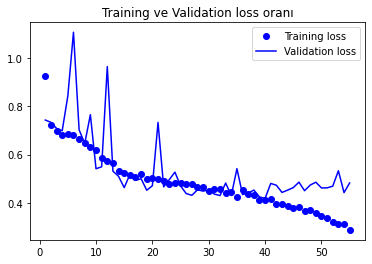

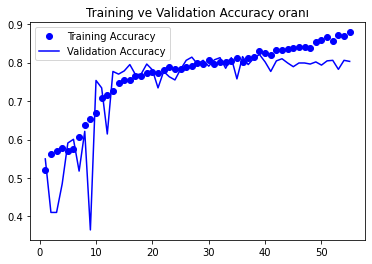

<Figure size 432x288 with 0 Axes>

In [8]:
if TRAINING_MODE:
    model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    earlystopper = EarlyStopping(patience=15, verbose=1)

    checkpoint = ModelCheckpoint(modelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
    callbacks_list = [checkpoint, earlystopper]

    history = model.fit(X_train/255.0, Y_train, validation_data=(X_test/255.0, Y_test), batch_size=16, epochs=200, callbacks=callbacks_list)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training ve Validation loss oranı')
    plt.legend()
    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training ve Validation Accuracy oranı')
    plt.legend()
    plt.figure()
else:
    model = load_model(modelName)

In [9]:
model = load_model(modelName)

df_test = pd.DataFrame()

df_test['type'] = Y_test

df_test = df_test.reset_index(drop=True)

df_test.head(10)

,type
0,False
1,True
2,False
3,False
4,True
5,False
6,True
7,True
8,False
9,False


In [10]:
preds = model.predict(X_test/255.0)

df_test['preds'] = np.round(preds)
df_test['preds'] = df_test['preds'].apply(np.int)

wrongs_df = df_test.loc[df_test['type'] != df_test['preds']]

print(f"{len(df_test)} hücre fotoğrafı arasından {len(wrongs_df)} tanesi yanlış tahmin edildi. Doğruluk oranı \
%{100 - (len(wrongs_df) * 100 / len(df_test))}")

df_test.head(10)

726 hücre fotoğrafı arasından 130 tanesi yanlış tahmin edildi. Doğruluk oranı %82.09366391184574


,type,preds
0,False,0
1,True,0
2,False,1
3,False,0
4,True,1
5,False,0
6,True,1
7,True,1
8,False,0
9,False,0


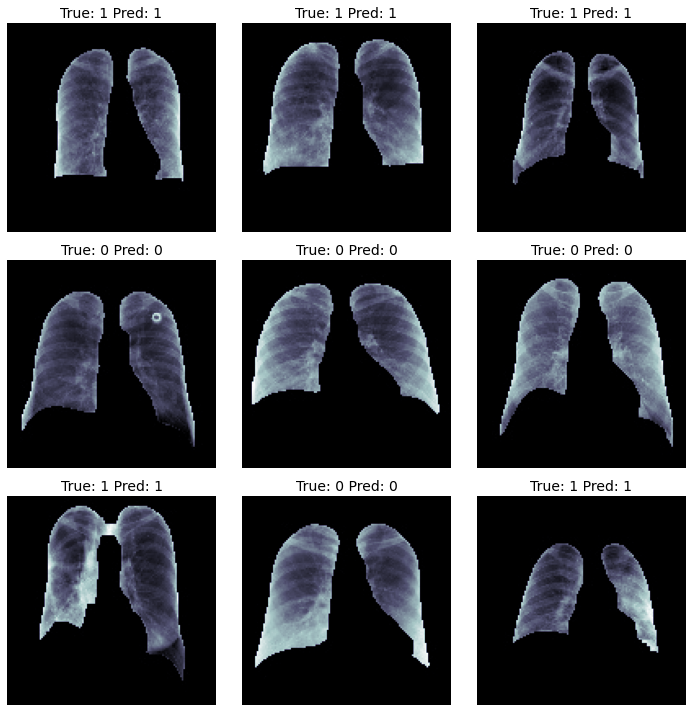

In [11]:
plt.figure(figsize=(10,10))
plt.axis('Off')

start_from = 10

for i in range(1, 10):
    plt.subplot(3,3,i)
    test_image = X_test[i + start_from, :, :, 0]
    plt.imshow((test_image), cmap=plt.cm.bone)

    true = df_test.loc[i + start_from, 'type']
    pred = df_test.loc[i + start_from, 'preds']
    result = 'True: ' + str(int(true)) + ' Pred: ' + str(pred)

    plt.title(result, fontsize=14)
    plt.axis('off')


plt.tight_layout()
plt.show()

In [12]:
model = load_model(modelName)

img_list = os.listdir("deneme")

mask_model = load_model("model.h5")

img_count = len(img_list)

X_test_priv = np.zeros((img_count + 1, IMG_HEIGHT, IMG_WIDTH))

virtual_index = 0
for img_name in img_list:
    img_file = "deneme\\" + img_name
    
    x = np.zeros((1, IMG_HEIGHT, IMG_WIDTH))
    
    img1 = readImages(img_file, is_gray=0)
    
    x[0] = img1
    
    img = (mask_model.predict(x/255.)*255.0)[0]
        
    img = fillHoles(img)
    img = removeSmallObjects(img, min_area = 200)
    img = cv2.bitwise_and(img1, img1, mask=img.astype(np.uint8))
    
    X_test_priv[virtual_index] = img
    virtual_index += 1


X_test_priv = X_test_priv.reshape(-1, 128, 128, 1)
preds = model.predict(X_test_priv/255.0)

plt.figure(figsize=(20,20))
plt.axis('Off')

for i in range(0, img_count):
    plt.subplot(1, img_count, i + 1)
    test_image = X_test_priv[i]
    plt.imshow(test_image, cmap=plt.cm.bone)
    plt.title(f'Pred: {int(preds[i])}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

FileNotFoundError: [WinError 3] Sistem belirtilen yolu bulamıyor: 'deneme'